## Regresion Lineal en Tensorflow

En este proyecto  trataremos predecir los precios de la casa utilizando regresion lineal y reducir el gradient.

Ecuacion a utilizar:
$ h(x) = wx +b$

In [1]:

import numpy as np
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%load_ext tensorboard


In [2]:
 # read data set
data = np.load('C:\R_File\Master of Data Science\Python\Project\proyecto_data\proyecto_training_data.npy') 


In [3]:
# Crear Dataframe  y normalizar los datos

casadf = pd.DataFrame(data =data, columns = ["precio", "Calif", "fsqrt","trooms","yearbuilt","LotFrontage"])
casadf['precio']= casadf['precio']/1000
casadf['fsqrt']= casadf['fsqrt']/1000
casadf.fillna(0,inplace=True)
casadf.describe(include='all')

,precio,Calif,fsqrt,trooms,yearbuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180.921196,6.099315,1.162627,6.517808,1971.267808,57.623288
std,79.442503,1.382997,0.386588,1.625393,30.202904,34.664304
min,34.900000,1.000000,0.334000,2.000000,1872.000000,0.000000
25%,129.975000,5.000000,0.882000,5.000000,1954.000000,42.000000
50%,163.000000,6.000000,1.087000,6.000000,1973.000000,63.000000
75%,214.000000,7.000000,1.391250,7.000000,2000.000000,79.000000
max,755.000000,10.000000,4.692000,14.000000,2010.000000,313.000000


In [4]:
casadf.corr(method='pearson', min_periods=1)

,precio,Calif,fsqrt,trooms,yearbuilt,LotFrontage
precio,1.000000,0.790982,0.605852,0.533723,0.522897,0.209624
Calif,0.790982,1.000000,0.476224,0.427452,0.572323,0.176561
fsqrt,0.605852,0.476224,1.000000,0.409516,0.281986,0.245181
trooms,0.533723,0.427452,0.409516,1.000000,0.095589,0.221396
yearbuilt,0.522897,0.572323,0.281986,0.095589,1.000000,0.036853
LotFrontage,0.209624,0.176561,0.245181,0.221396,0.036853,1.000000


**Correlation de Variables.**
Basado la correlacion de los datos podemos indicar que:

* ``` Calif ``` con un $R = 0.79$
* ``` fsqrt ``` con un $R = 0.61$

Son las mas predictivas

In [5]:
#Random seed para reproducibilidad de los resultados

np.random.seed(24)

#Shuffle de datos
df = casadf.sample(frac = 1)


#Split Data entre entrenamiento y test

msk = np.random.rand(len(df)) < 0.8

train = df[msk]

test = df[~msk]

print('entrenamiento: ',len(train), ', set de prueba: ', len(test))

entrenamiento:  1187 , set de prueba:  273


### Modelo de regresión lineal mediante ***gradient descent***

El modelo de regresión lineal se entrenará utilizando la siguiente función de costo.

Función de costo:

$C(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (y_{i} − h(x_i))^2$

donde:

* $y_{i}$ : Valor real de cada dato en el dataset
* $wx_{i}+b$ : Valor predecido por el modelo


*Gradient descent*:

$w = w - \alpha \frac{1}{n} \sum_{i=1}^{n} (y_i - h(x_i))*m)$

$b = b - \alpha \frac{1}{n} \sum_{i=1}^{n} (y_i − h(x_i))$


Los valores de $m$ y $b$ son actualizados iterativamente hasta minimizar el error.

In [40]:
class regression_lineal:
    def __init__ (self):
        # vector.
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [1,2], initializer = tf.zeros_initializer())
        
    # Funcion para Y_hat
    def __call__(self, x):
        with tf.name_scope("model"):
            return tf.matmul(self.w,x)
    # Funcion gradient descent
    def update(self, x, y, lr):
        with tf.name_scope("error"):
            error = self.error(x,y)
            # Escalar
            error_summary = tf.summary.scalar("ErrorSummary", error)
        gradient = tf.gradients(error, [self.w])
        updated_w = tf.assign(self.w, self.w -lr * gradient[0])
        return updated_w, error, error_summary
    
    # MSE
    def error(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - self(x)))
        return error

In [41]:
y = train["precio"]
x = train["Calif"]
x = np.array([x, np.ones_like(x)], dtype = "float64")
# Funcion para entrenamiento

def training(lr, epochs, frecprint):
    # String para definicion de experimento
    string = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización
        modelo = regression_lineal()
        # placeholders
        tensorflow_x = tf.placeholder(tf.float32, [2,len(train["Calif"])], "tensorflow_x")
        tensorflow_y = tf.placeholder(tf.float32, [len(train["precio"])], "tensorflow_y")
        #  entrenamiento
        update_parameters = modelo.update(tensorflow_x, tensorflow_y, lr)
        
        # tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        with tf.train.MonitoredSession() as session:
            feed_dict = {tensorflow_x:x, tensorflow_y:y}
            for i in range(epochs+1):
                
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
            
                if (i)%frecprint == 0:
                    # epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # visualizarlos en tensorboard
                    writer.add_summary(training[2], i)
                    print("Epoch: ", i, "Weights: ", weights, "Cost: ", training[1])
                    print("-------------------------------------------------------------------------")
                    
            writer.close()

#### Representación de gráfica de modelo
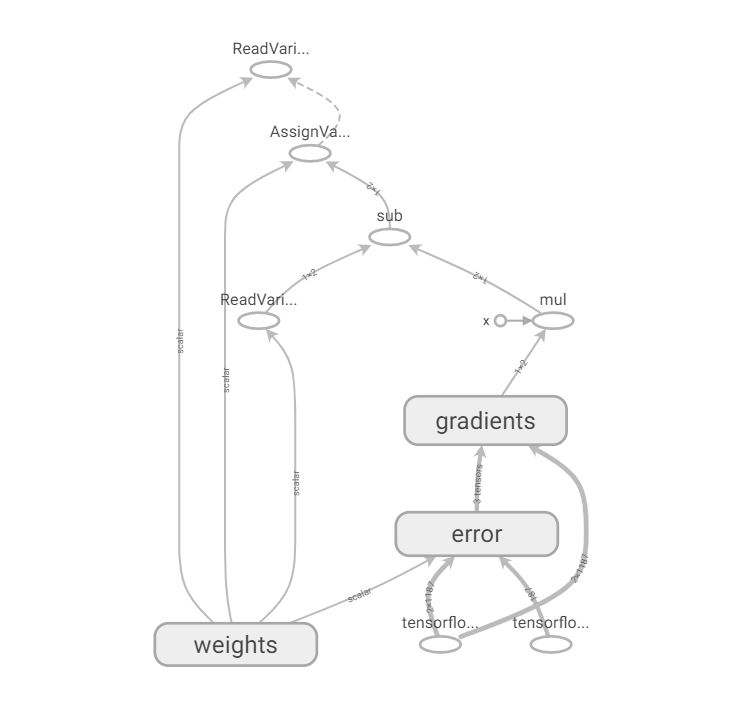

In [78]:
# test 2
training(0.001, 1000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[1.1857771 0.1804235]] Cost:  19256.78
-------------------------------------------------------------------------
Epoch:  500 Weights:  [[29.889708   2.3489835]] Cost:  1318.4613
-------------------------------------------------------------------------
Epoch:  1000 Weights:  [[30.233927    0.14390466]] Cost:  1308.4985
-------------------------------------------------------------------------


In [72]:
# test 2
training(0.02, 20000,1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[23.71554    3.6084697]] Cost:  19256.78
-------------------------------------------------------------------------
Epoch:  1000 Weights:  [[ 38.81343  -54.816933]] Cost:  1135.3728
-------------------------------------------------------------------------
Epoch:  2000 Weights:  [[ 42.45283 -78.13116]] Cost:  1105.4957
-------------------------------------------------------------------------


In [73]:
# test 3
training(0.03, 2000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[35.573307   5.4127045]] Cost:  19256.78
-------------------------------------------------------------------------
Epoch:  500 Weights:  [[ 37.24118  -44.744984]] Cost:  1156.3888
-------------------------------------------------------------------------
Epoch:  1000 Weights:  [[ 41.053524 -69.16711 ]] Cost:  1113.9144
-------------------------------------------------------------------------
Epoch:  1500 Weights:  [[ 42.9452  -81.28533]] Cost:  1103.4567
-------------------------------------------------------------------------
Epoch:  2000 Weights:  [[ 43.883842 -87.29831 ]] Cost:  1100.8821
-------------------------------------------------------------------------


In [74]:
# test 4
training(0.04, 2000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[47.43108    7.2169394]] Cost:  19256.78
-------------------------------------------------------------------------
Epoch:  500 Weights:  [[ 38.821655 -54.869617]] Cost:  1135.342
-------------------------------------------------------------------------
Epoch:  1000 Weights:  [[ 42.45708  -78.158394]] Cost:  1105.4858
-------------------------------------------------------------------------
Epoch:  1500 Weights:  [[ 43.88488 -87.30497]] Cost:  1100.8809
-------------------------------------------------------------------------
Epoch:  2000 Weights:  [[ 44.44563 -90.89719]] Cost:  1100.1705
-------------------------------------------------------------------------


In [75]:
# test 5
training(0.05, 2000,300)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[59.28885   9.021174]] Cost:  19256.78
-------------------------------------------------------------------------
Epoch:  300 Weights:  [[220.94073  -16.131763]] Cost:  686176.8
-------------------------------------------------------------------------
Epoch:  600 Weights:  [[1176.5165   108.04187]] Cost:  26175340.0
-------------------------------------------------------------------------
Epoch:  900 Weights:  [[7061.656  1014.3259]] Cost:  1000108160.0
-------------------------------------------------------------------------
Epoch:  1200 Weights:  [[43429.27   6685.236]] Cost:  38213743000.0
-------------------------------------------------------------------------
Epoch:  1500 Weights:  [[268226.6    41773.523]] Cost:  1460133400000.0
-------------------------------------------------------------------------
Epoch:  1800 Weights:  [[1657787.6  2586

### Conclusion


Tras la realización de los experimentos se observaron los siguientes resultados:

* Un *learning rate* de 0.001 es el mejor para reducir el gradient.
* Un *learning rate* mayor de 0.04 causa divergencia 

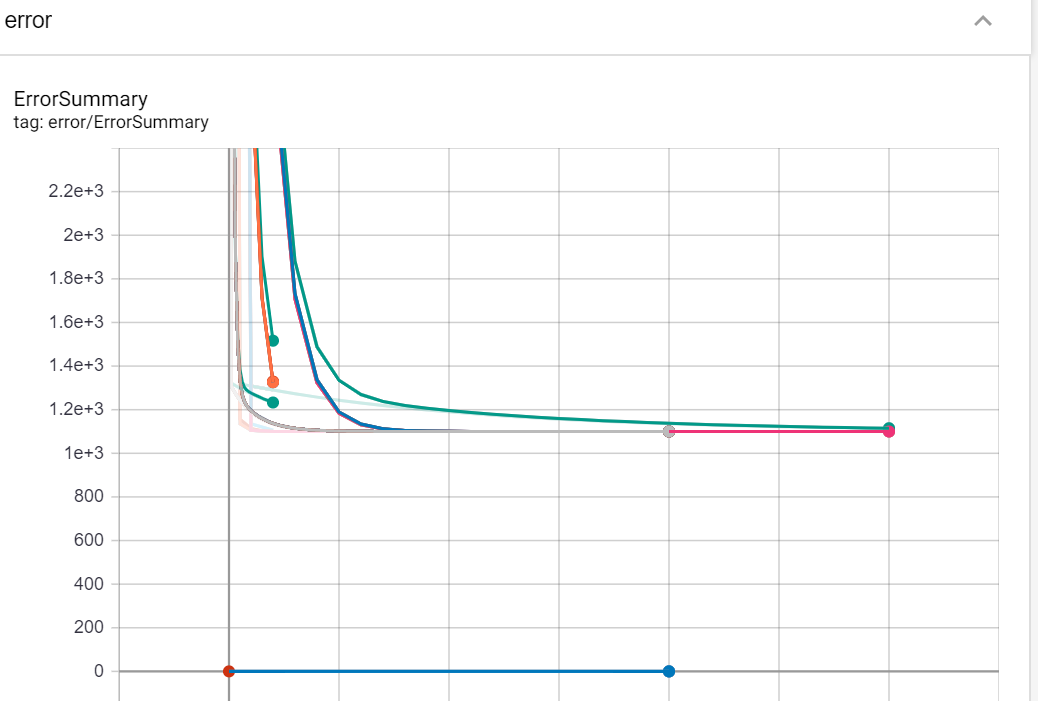

In [76]:
%tensorboard --logdir ./graphs  --port 6006

Reusing TensorBoard on port 6006 (pid 5224), started 4 days, 0:28:48 ago. (Use '!kill 5224' to kill it.)